# 利用GAN生成MNIST

In [1]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt

# 導入數據

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


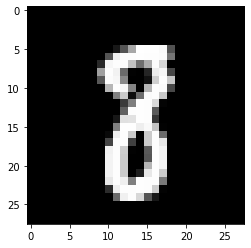

In [4]:
img = mnist.train.images[50]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

# Inputs

In [5]:
def get_inputs(real_size, noise_size):
    """
    真實圖像tensor與噪聲圖像tensor
    """
    real_img = tf.placeholder(tf.float32, [None, real_size], name='real_img')
    noise_img = tf.placeholder(tf.float32, [None, noise_size], name='noise_img')
    
    return real_img, noise_img

# generator

In [6]:
def get_generator(noise_img, n_units, out_dim, reuse=False, alpha=0.01):
    """
    生成器
    
    noise_img: 生成器的輸入
    n_units: 隱層單元個數
    out_dim: 生成器輸出tensor的size，這裡應該為32*32=784
    alpha: leaky ReLU係數
    """
    with tf.variable_scope("generator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(noise_img, n_units)
        # leaky ReLU
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        # dropout
        hidden1 = tf.layers.dropout(hidden1, rate=0.2)

        # logits & outputs
        logits = tf.layers.dense(hidden1, out_dim)
        outputs = tf.tanh(logits)
        
        return logits, outputs

# Discriminator

In [7]:
def get_discriminator(img, n_units, reuse=False, alpha=0.01):
    """
    判別器
    
    n_units: 隱層結點數量
    alpha: Leaky ReLU係數
    """
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(img, n_units)
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        # logits & outputs
        logits = tf.layers.dense(hidden1, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs


# 定義參數

In [8]:

# 定義參數
# 真實圖像的size
img_size = mnist.train.images[0].shape[0]
# 傳入給generator的噪聲size
noise_size = 100
# 生成器隱層參數
g_units = 128
# 判別器隱層參數
d_units = 128
# leaky ReLU的參數
alpha = 0.01
# learning_rate
learning_rate = 0.001
# label smoothing
smooth = 0.1

# 建構網路

In [9]:
tf.reset_default_graph()

real_img, noise_img = get_inputs(img_size, noise_size)

# generator
g_logits, g_outputs = get_generator(noise_img, g_units, img_size)

# discriminator
d_logits_real, d_outputs_real = get_discriminator(real_img, d_units)
d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, d_units, reuse=True)

# Loss

這裡簡單說一下Loss的計算方式，由於我們上面構建了兩個神經網絡：generator和discriminator，因此需要分別計算loss。

discriminator discriminator的目的在於對於給定的真圖片，識別為真（1），對於generator生成的圖片，識別為假（0），因此它的loss包含了真實圖片的loss和生成器圖片的loss兩部分。

generator generator的目的在於讓discriminator識別不出它的圖片是假的，如果用1代表真，0代表假，那麼generator生成的圖片經過discriminator後要輸出為1，因為generator想要騙過discriminator。

In [10]:
# discriminator的loss
# 識別真實圖片
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                     labels=tf.ones_like(d_logits_real)) * (1 - smooth))
# 識別生成的圖片
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                     labels=tf.zeros_like(d_logits_fake)))
# 總體loss
d_loss = tf.add(d_loss_real, d_loss_fake)

# generator的loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                labels=tf.ones_like(d_logits_fake)) * (1 - smooth))

# Optimizer


In [11]:
train_vars = tf.trainable_variables()

# generator中的tensor
g_vars = [var for var in train_vars if var.name.startswith("generator")]
# discriminator中的tensor
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]

# optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

# 訓練

In [13]:
# batch_size
batch_size = 64
# 訓練迭代輪數
epochs = 300
# 抽取樣本數
n_sample = 25

# 存儲測試樣例
samples = []
# 存儲loss
losses = []
# 保存生成器變量
saver = tf.train.Saver(var_list = g_vars)
# 開始訓練
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for batch_i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            # 對圖像像素進行scale，這是因為tanh輸出的結果介於(-1,1),real和fake圖片共享discriminator的參數
            batch_images = batch_images*2 - 1
            
            # generator的輸入噪聲
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={real_img: batch_images, noise_img: batch_noise})
            _ = sess.run(g_train_opt, feed_dict={noise_img: batch_noise})
        
        # 每一輪結束計算loss
        train_loss_d = sess.run(d_loss,
                                feed_dict = {real_img: batch_images,
                                             noise_img: batch_noise})
        # real img loss
        train_loss_d_real = sess.run(d_loss_real,
                                     feed_dict = {real_img: batch_images,
                                                 noise_img: batch_noise})
        # fake img loss
        train_loss_d_fake = sess.run(d_loss_fake,
                                    feed_dict = {real_img: batch_images,
                                                 noise_img: batch_noise})
        # generator loss
        train_loss_g = sess.run(g_loss,
                                feed_dict = {noise_img: batch_noise})
        
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}(Real: {:.4f} + Fake: {:.4f})...".format(train_loss_d, train_loss_d_real, train_loss_d_fake),
              "Generator Loss: {:.4f}".format(train_loss_g))
        # 記錄各類loss值
        losses.append((train_loss_d, train_loss_d_real, train_loss_d_fake, train_loss_g))
        
        # 抽取樣本後期進行觀察
        sample_noise = np.random.uniform(-1, 1, size=(n_sample, noise_size))
        gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                               feed_dict={noise_img: sample_noise})
        samples.append(gen_samples)
        
        # 存儲checkpoints
        saver.save(sess, './checkpoints/generator.ckpt')

# 將sample的生成數據記錄下來
with open('train_samples.pkl', 'wb') as f:
    pickle.dump(samples, f)

Epoch 1/300... Discriminator Loss: 0.0697(Real: 0.0062 + Fake: 0.0636)... Generator Loss: 3.5988
Epoch 2/300... Discriminator Loss: 3.0757(Real: 1.1996 + Fake: 1.8761)... Generator Loss: 2.0503
Epoch 3/300... Discriminator Loss: 2.3850(Real: 0.8300 + Fake: 1.5550)... Generator Loss: 2.3985
Epoch 4/300... Discriminator Loss: 1.3005(Real: 0.8312 + Fake: 0.4693)... Generator Loss: 3.0648
Epoch 5/300... Discriminator Loss: 0.8343(Real: 0.4950 + Fake: 0.3393)... Generator Loss: 1.2593
Epoch 6/300... Discriminator Loss: 0.6109(Real: 0.2829 + Fake: 0.3280)... Generator Loss: 1.6707
Epoch 7/300... Discriminator Loss: 0.9315(Real: 0.5302 + Fake: 0.4013)... Generator Loss: 1.1997
Epoch 8/300... Discriminator Loss: 0.4938(Real: 0.2965 + Fake: 0.1973)... Generator Loss: 1.8236
Epoch 9/300... Discriminator Loss: 0.9903(Real: 0.5603 + Fake: 0.4300)... Generator Loss: 1.5438
Epoch 10/300... Discriminator Loss: 1.1871(Real: 0.5714 + Fake: 0.6157)... Generator Loss: 1.6560
Epoch 11/300... Discriminator

# 繪製loss曲線

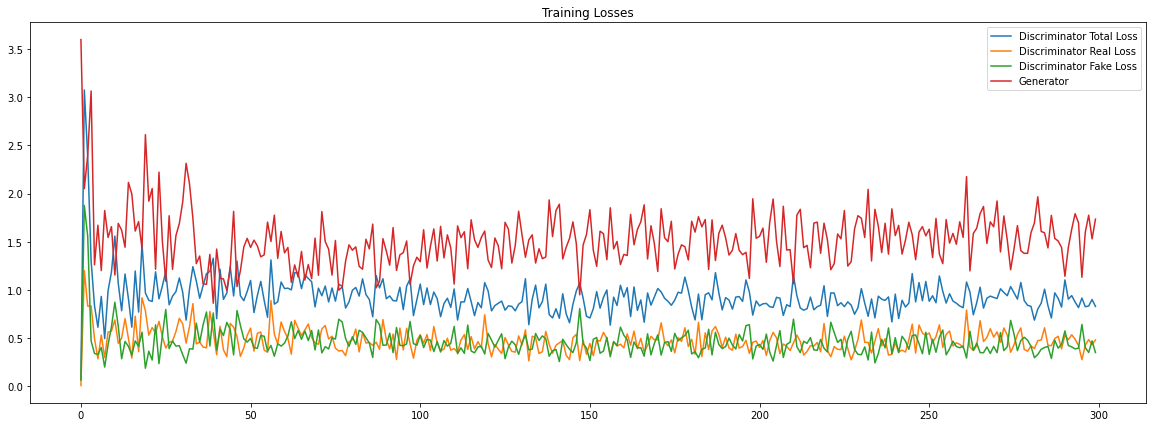

In [14]:
fig, ax = plt.subplots(figsize=(20,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator Total Loss')
plt.plot(losses.T[1], label='Discriminator Real Loss')
plt.plot(losses.T[2], label='Discriminator Fake Loss')
plt.plot(losses.T[3], label='Generator')
plt.title("Training Losses")
plt.legend()

# 顯示圖像

In [16]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pickle.load(f)

In [17]:
def view_samples(epoch, samples):
    """
    epoch代表第幾次迭代的圖像
    samples為我們的採樣結果
    """
    fig, axes = plt.subplots(figsize=(7,7), nrows=5, ncols=5, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch][1]): #這裡samples [epoch] [1]代表生成的圖像結果，而[0]代表對應的登錄
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

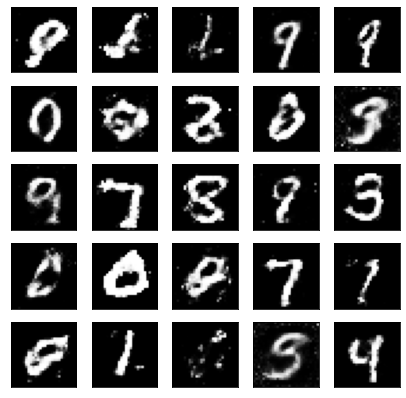

In [18]:
_ = view_samples(-1, samples) # 顯示最後一輪的outputs

# 顯示整個生成過程圖片


In [19]:
# 指定要查看的輪次
epoch_idx = [0, 5, 10, 20, 40, 60, 80, 100, 150, 250] # 一共300輪，不要越界
show_imgs = []
for i in epoch_idx:
    show_imgs.append(samples[i][1])

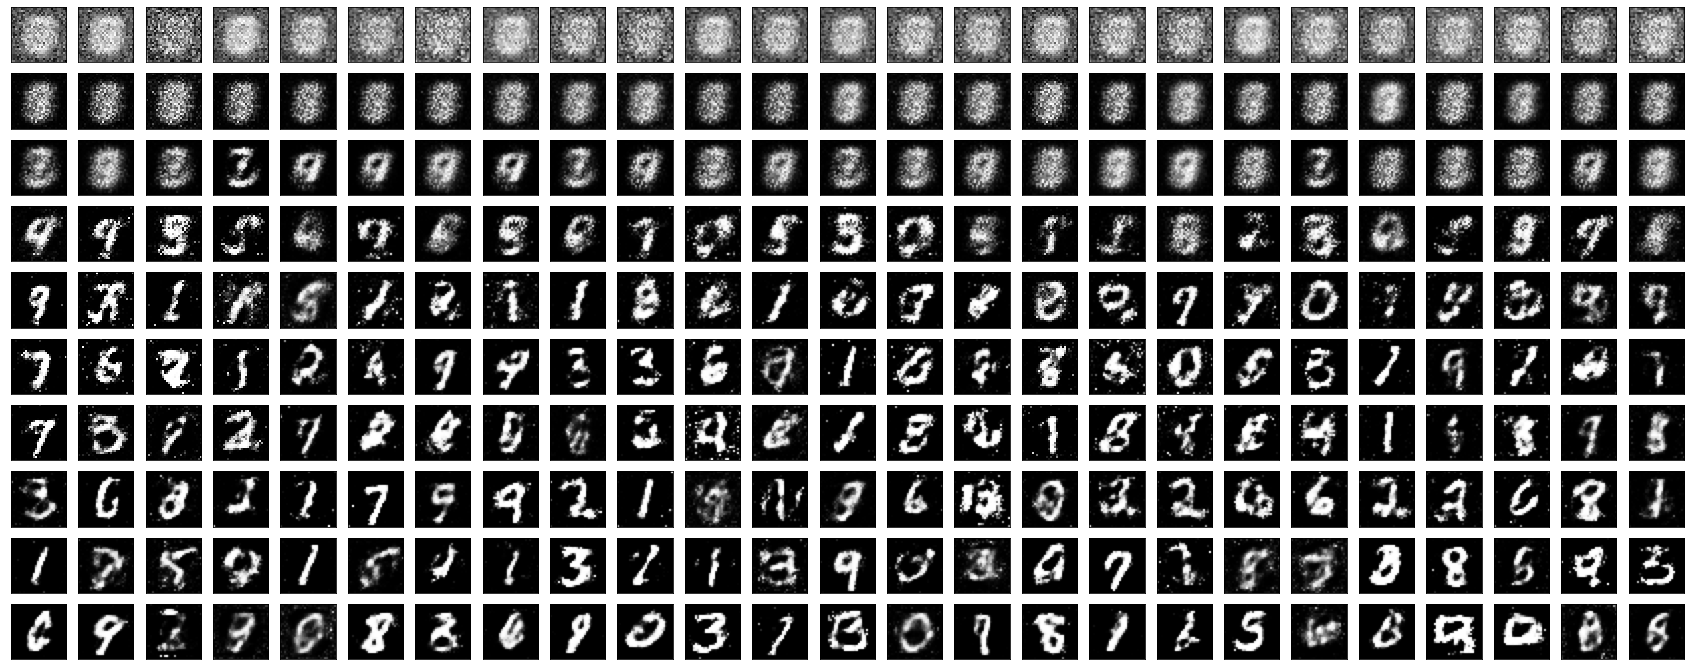

In [20]:
# 指定圖片形狀
rows, cols = 10, 25
fig, axes = plt.subplots(figsize=(30,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

idx = range(0, epochs, int(epochs/rows))

for sample, ax_row in zip(show_imgs, axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

# 生成新的圖片

In [21]:
# 加載我們的生成器變量
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_noise = np.random.uniform(-1, 1, size=(25, noise_size))
    gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                           feed_dict={noise_img: sample_noise})

INFO:tensorflow:Restoring parameters from checkpoints\generator.ckpt


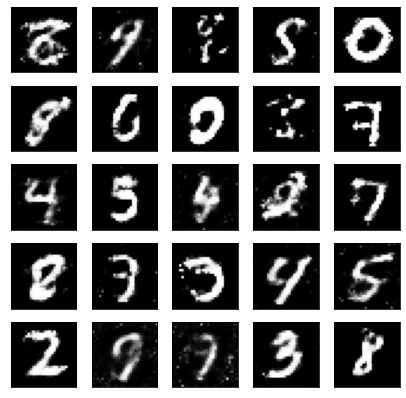

In [22]:
_ = view_samples(0, [gen_samples])
